# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### 2. Define the Architecture of the Policy

In [66]:
env = gym.make('LunarLander-v2')
env.seed(0)
nO = int(env.observation_space.shape[0])
nA = 2 # int(env.action_space)
print('observation space:', nO)
print('action space:', nA)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



observation space: 8
action space: 2


In [67]:
cart_env = gym.make('CartPole-v0')
cart_env.seed(0)
cart_nO = int(cart_env.observation_space.shape[0])
cart_nA = 2 # int(env.action_space)
print('cart_observation space:', cart_nO)
print('cart_action space:', cart_nA)

cart_observation space: 4
cart_action space: 2


In [88]:
class Policy(nn.Module):
    def __init__(self, s_size=nO, h_size=nO*4, a_size=nA):
        super(Policy, self).__init__()
        self.intake = nn.Linear(s_size, h_size)
        self.hidden = nn.Linear(h_size, a_size*4)
        self.outward = nn.Linear(a_size*4, a_size)

    def forward(self, x):
        x = F.relu(self.intake(x))
        x = F.relu(self.hidden(x))
        x = self.outward(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [90]:
cart_policy = Policy(s_size=cart_nO, h_size=cart_nO*4, a_size=cart_nA).to(device)
cart_optimizer = optim.Adam(cart_policy.parameters(), lr=1e-2)

### 3. Train the Agent with REINFORCE

In [91]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

In [72]:
[next for next in policy.parameters()]

[Parameter containing:
 tensor([[-0.1655, -0.2043,  0.0171,  0.2162, -0.0858, -0.1263, -0.1713,
          -0.1815],
         [ 0.1878,  0.3469, -0.2141,  0.2322, -0.0742,  0.2738,  0.3385,
           0.3133],
         [-0.0464,  0.2861, -0.2450, -0.1576,  0.1960,  0.0184, -0.1795,
          -0.2281],
         [ 0.3534, -0.1866, -0.2784,  0.1072, -0.1359, -0.0335, -0.0122,
           0.0955],
         [ 0.2639, -0.3503,  0.0184,  0.0543, -0.1865,  0.0020, -0.3316,
           0.0733],
         [ 0.1176, -0.3353, -0.2398, -0.1524,  0.2941, -0.2757,  0.3318,
           0.3064],
         [ 0.0398,  0.0091, -0.1224, -0.1890,  0.1665, -0.0444,  0.0488,
           0.3178],
         [ 0.2425,  0.1927, -0.0090,  0.1210, -0.0376, -0.2445,  0.1514,
          -0.0827],
         [-0.1807, -0.3418,  0.0652, -0.0742, -0.2619, -0.1733, -0.0233,
          -0.1535],
         [-0.0997, -0.1265,  0.2504, -0.2827, -0.1865, -0.1020, -0.2689,
          -0.0308],
         [-0.3211,  0.1366, -0.2017,  0.1165,  

In [92]:
# REINFORCE
def reinforce(env=env, policy=policy, optimizer=optimizer, 
              n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
        ### STORE WEIGHTS
            break
        
    return (scores, policy)
    


In [93]:
(cart_scores, cart_policy) = reinforce(env=cart_env, policy=cart_policy, optimizer=cart_optimizer, 
                                       n_episodes=2500, max_t=300)

Episode 100	Average Score: 12.81
Episode 200	Average Score: 11.79
Episode 300	Average Score: 18.92
Episode 400	Average Score: 20.02
Episode 500	Average Score: 20.55
Episode 600	Average Score: 28.82
Episode 700	Average Score: 19.76
Episode 800	Average Score: 23.10
Episode 900	Average Score: 76.70
Episode 1000	Average Score: 27.52
Episode 1100	Average Score: 42.87
Episode 1200	Average Score: 50.55
Episode 1300	Average Score: 80.30
Episode 1400	Average Score: 49.53
Episode 1500	Average Score: 45.67
Episode 1600	Average Score: 89.92
Episode 1700	Average Score: 85.83
Episode 1800	Average Score: 110.68
Episode 1900	Average Score: 138.55
Episode 2000	Average Score: 83.64
Episode 2100	Average Score: 131.88
Episode 2200	Average Score: 150.95
Environment solved in 2164 episodes!	Average Score: 195.41


In [94]:
(scores, policy) = reinforce(policy=policy, n_episodes=2500, max_t=800)

Episode 100	Average Score: -463.61
Episode 200	Average Score: -527.78
Episode 300	Average Score: -538.35
Episode 400	Average Score: -467.57
Episode 500	Average Score: -467.89
Episode 600	Average Score: -385.30
Episode 700	Average Score: -390.75
Episode 800	Average Score: -355.99
Episode 900	Average Score: -343.36
Episode 1000	Average Score: -335.53
Episode 1100	Average Score: -337.74
Episode 1200	Average Score: -352.19
Episode 1300	Average Score: -297.98
Episode 1400	Average Score: -272.15
Episode 1500	Average Score: -272.53
Episode 1600	Average Score: -282.48
Episode 1700	Average Score: -276.28
Episode 1800	Average Score: -275.38
Episode 1900	Average Score: -234.76
Episode 2000	Average Score: -223.45
Episode 2100	Average Score: -203.43
Episode 2200	Average Score: -204.74
Episode 2300	Average Score: -194.00
Episode 2400	Average Score: -196.52
Episode 2500	Average Score: -207.94


### 4. Plot the Scores

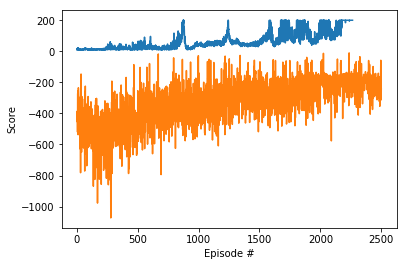

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(cart_scores)+1), cart_scores)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

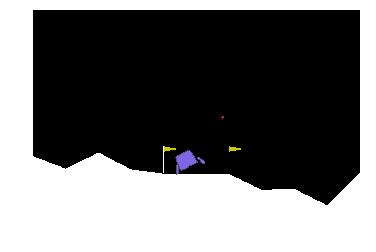

In [104]:
env = gym.make('LunarLander-v2')
env.seed(0)

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

#env.close()

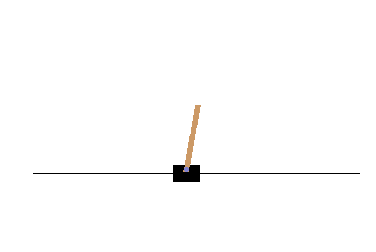

In [102]:
cart_env = gym.make('CartPole-v0')
cart_env.seed(0)

cart_state = cart_env.reset()
img = plt.imshow(cart_env.render(mode='rgb_array'))
for t in range(1000):
    cart_action, _ = cart_policy.act(cart_state)
    img.set_data(cart_env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    cart_state, reward, done, _ = cart_env.step(action)
    if done:
        break 